In [1]:
# Assignment 3: Score Based Generative Modeling Through Stochastic Differential Equations


## Submission Guidelines

- If it is more comfortable, you may submit either a python project with several files which define functions or a single python notebook that implements everything. The python notebook should include outputs, even if they are not the same outputs as the ones you submit in the zip.
- If you choose to submit using a python project, you must also submit a notebook that runs all relevant functions and generates all outputs (they don't need to be the same as the ones that are in the visualization zip, but we should be able to see that all functions run correctly). There should be two zips in this case: one containing all code files (including the notebook that replicates the outputs) and another containing the visualizations as done before.
- You may name the zip files as you wish, as long as your ID is in the name.
- All other requirements are based on the requirements in the syllabus.
- Reminder: You can play with the functions as much as you want to, and don't need to implement functions using the same parameters / names as what we provide. All changes that you make should be documented and should still do all the things you're required to do.import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
import numpy as np
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import socket
print("Hostname:", socket.gethostname())

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
import numpy as np
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from tqdm import tqdm
import os
import matplotlib.pyplot as plt

## Part 1: Visualizing SDEs Using Simulations


In this part, we will recreate part of Figure 2 in https://arxiv.org/pdf/2011.13456 using Euler's method for sampling from SDEs. In particular, we will be recreating the Variance Preserving SDE (DDPM's continuous form):

$$
d\textbf{x}_t = -\frac{1}{2}\beta_t \textbf{x}_t dt + \sqrt{\beta_t} d\textbf{w}_t
$$

Note that in the paper, Figure 2 is of the ALD based SDE, so it looks different than what you will be creating.

This part can be entirely run on your PC, without needing the VM or CUDA. We strongly recommend to run this part of the assignment locally. 

1. For $\textbf{x} \in \mathbb{R}$, formulate the ground truth distribution $p_t(\textbf{x}_t | \textbf{x}_0)$ and the function $\nabla_{\textbf{x}_t} \log p_t(\textbf{x}_t | \textbf{x}_0)$. Note $\Sigma_0 = 0$.
2. Train a simple model using the loss from tutorials 5/6 to approximate the marginal score: $\nabla_{\textbf{x}_t}\log p_t(\textbf{x}_t)$, for the above SDE.
3. Sample 100,000 values for $\textbf{x}_0$ following a mixture of Gaussians, probability 0.5 of being centered around -3 and 0.5 being centered around 3, with standard deviation 0.5. Advance them according to the SDE provided in DDPM, using Euler's method with `T=1000` and step size `1e-3`. What is the distribution we reached?
4. For 10,000 random starting points, advance them according to the probability flow ODE, using the score you learned. Note that despite the fact that you need the score to do this, *you are still advancing the points according to the forward process*! 
5. Now, reverse the process by sampling 10,000 samples from the prior distribution and taking reverse steps according to the reverse SDE using the score. To sample using Euler in the reverse process, see equation 46 in the paper linked above (in Appendix E, $\mathbf{f}\equiv \mu, \mathbf{G}\equiv \sigma$). Display the trajectory of 2 random starting points using the reverse SDE.
6. Bonus (2 points): Sample 10,000 points according to the reverse probability flow ODE and display the trajectory of two random starting points.

# part one

## part 1.1

![My Gyazo Image](https://i.gyazo.com/24c6d2d13ad48478d9b47d7384fc470a.png)

## Part 1.2
Train a simple model using the loss from tutorials 5/6 to approximate the marginal score: $\nabla_{\textbf{x}_t}\log p_t(\textbf{x}_t)$, for the above SDE.

In [27]:
beta_max = 20.0
beta_min = 0.1
device = 'cuda' if torch.cuda.is_available() else 'cpu'


def q_mean_and_var(x0, t,beta_max=20.0,beta_min= 0.1):
    alpha = torch.exp(-beta_min * t - 0.5 * (beta_max - beta_min) * t ** 2)
    mu = torch.sqrt(alpha) * x0
    sigma_squared = sigma_t_squared_batch(t)
    return mu,sigma_squared

def q_sample(n_samples = 10000):
    mix = torch.distributions.Categorical(probs=torch.tensor([0.5, 0.5]))
    components = torch.distributions.Normal(
    loc=torch.tensor([-3.0, 3.0]),
    scale=torch.tensor([0.5, 0.5])
)
    data_distribution = torch.distributions.MixtureSameFamily(mix, components)
    x0 = data_distribution.sample((n_samples,))
    return x0.to(device).unsqueeze(1)

def bar_lin_t(t,min_beta = 0.1,max_beta= 20.0):
        return (max_beta - min_beta) * t + min_beta

def sigma_t_squared_batch(batch_t,n_steps = 10000):
    B = batch_t.shape[0]
    batch_t = batch_t.view(-1)
    t = batch_t.unsqueeze(1)
    s = torch.linspace(0, 1, steps=n_steps).to(device)
    s = s.unsqueeze(0).expand(B, -1)
    ds = float(s[0, 1] - s[0, 0])
    t_exp = t.expand_as(s)
    delta = t_exp - s * t
    beta_s = bar_lin_t(s * t)
    exponent = torch.exp(-0.5 * ((beta_max - beta_min) * delta**2 + 2 * beta_min * delta))
    full_term = exponent * beta_s 
    sigma_squared = torch.trapz(full_term, dx=ds, dim=1) * batch_t

    return sigma_squared.unsqueeze(1)
    
    

In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

def sinusoidal_embedding(t, dim):
    half_dim = dim // 2
    emb = torch.exp(torch.arange(half_dim, device=t.device) * (-np.log(10000.0) / (half_dim - 1)))
    emb = t * emb
    return torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)

class ScoreNN(nn.Module):
    def __init__(self, hidden_dim=128, time_embed_dim=32):
        super().__init__()
        input_dim = 1 + time_embed_dim  # x + embedded t
        self.net = nn.Sequential(
            nn.utils.weight_norm(nn.Linear(input_dim, hidden_dim)),
            nn.ReLU(inplace=True),
            nn.utils.weight_norm(nn.Linear(hidden_dim, hidden_dim)),
            nn.ReLU(inplace=True),
            nn.utils.weight_norm(nn.Linear(hidden_dim, hidden_dim)),
            nn.ReLU(inplace=True),
            nn.utils.weight_norm(nn.Linear(hidden_dim, 1))
        )
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x, t):
        time_emb = sinusoidal_embedding(t, dim=32)  # t should be (B, 1)
        xtt = torch.cat([x, time_emb], dim=1)
        return self.net(xtt)

In [32]:
#Training:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ScoreNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
model.train() 

n_epochs = 40000
batch_size = 512

for epoch in range(n_epochs):
    x0 = q_sample(batch_size)
    t = torch.rand(batch_size,1,device=device)
    mu , sigma_squared = q_mean_and_var(x0,t)
    sigma_squared = sigma_squared.clamp(min=1e-5)
    xt = mu + torch.sqrt(sigma_squared) * torch.randn_like(mu)
    #score from 1.1
    score =  - (xt - mu) / sigma_squared
    score_pred = model(xt,t)
    loss = ((score - score_pred)**2).mean() #mse
    optimizer.zero_grad()
    loss.backward()
    # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")
        
torch.save(model.state_dict(), "score_model_part1.pth")


/usr/local/lib/python3.11/dist-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


Epoch 0, Loss: 39.8274
Epoch 500, Loss: 76.0830
Epoch 1000, Loss: 90.2124
Epoch 1500, Loss: 272.2634
Epoch 2000, Loss: 58.8427
Epoch 2500, Loss: 152.2362
Epoch 3000, Loss: 13.3823
Epoch 3500, Loss: 13.5719
Epoch 4000, Loss: 38.5677
Epoch 4500, Loss: 25.6599
Epoch 5000, Loss: 182.7574
Epoch 5500, Loss: 44.6018
Epoch 6000, Loss: 10.6024
Epoch 6500, Loss: 112.2857
Epoch 7000, Loss: 25.9068
Epoch 7500, Loss: 4.4500
Epoch 8000, Loss: 6.3410
Epoch 8500, Loss: 310.6623
Epoch 9000, Loss: 5.4930
Epoch 9500, Loss: 45.7683
Epoch 10000, Loss: 7.8020
Epoch 10500, Loss: 20.1248
Epoch 11000, Loss: 200.3781
Epoch 11500, Loss: 9.5935
Epoch 12000, Loss: 10.0413
Epoch 12500, Loss: 18.6261
Epoch 13000, Loss: 32.9948
Epoch 13500, Loss: 48.2133
Epoch 14000, Loss: 29.0952
Epoch 14500, Loss: 22.4125
Epoch 15000, Loss: 36.7590
Epoch 15500, Loss: 29.3102
Epoch 16000, Loss: 24.4473
Epoch 16500, Loss: 19.7627
Epoch 17000, Loss: 11.3315
Epoch 17500, Loss: 208.3145
Epoch 18000, Loss: 15.6967
Epoch 18500, Loss: 130.

## Part 1.3
"""3. Sample 100,000 values for $\textbf{x}_0$ following a mixture of Gaussians, probability 0.5 of being centered 
around -3 and 0.5 being centered around 3, with standard deviation 0.5. Advance them according 
to the SDE provided in DDPM, using Euler's method with `T=1000` and step size `1e-3`. What is the distribution we reached?

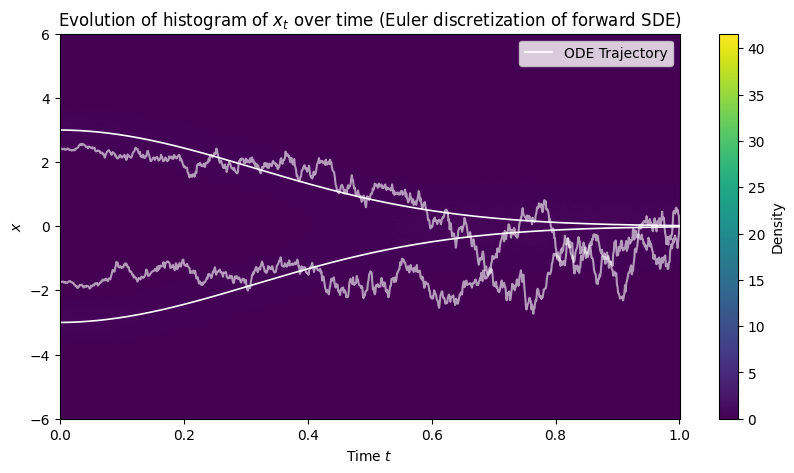

In [30]:
#pararmeters
dt = 1e-3
n_steps = 1000
T = n_steps * dt
beta_min, beta_max = 0.1, 20.0
time_points = np.linspace(0, T, n_steps + 1)
x0 = q_sample(10000)

#simulation of the full forward SDE paths
x_all = torch.zeros(n_steps + 1, 10000, device=device)
x_all[0] = x0.squeeze()

x = x0.clone()
for step in range(n_steps):
    t = (step - 1) * dt
    beta = bar_lin_t(torch.tensor(t, device=device))
    drift = (-0.5) * beta * x
    diff = torch.sqrt(beta)
    noise = torch.randn_like(x)
    x = x + drift * dt + diff * np.sqrt(dt) * noise
    x_all[step] = x.squeeze()
x_all = x_all.cpu().numpy()

x_bins = np.linspace(-6, 6, 500)
t_bins = np.linspace(0, T, n_steps + 1)

heatmap = np.zeros((len(x_bins)-1, len(t_bins)))

for t_idx in range(len(t_bins)):
    hist, _ = np.histogram(x_all[t_idx], bins=x_bins, density=True)
    heatmap[:, t_idx] = hist

x0_ode = torch.tensor([[-3.0], [3.0]], device=device)
x_ode = x0_ode.clone()

ode_trajs = [[], []]  # store for each starting point

for step in range(n_steps + 1):
    t = step * dt
    for i in range(2):
        ode_trajs[i].append(x_ode[i].item())
        beta = bar_lin_t(torch.tensor(t, device=device))
        dx = -0.5 * beta * x_ode[i]
        x_ode[i] = x_ode[i] + dx * dt

# Convert to arrays
ode1 = np.array(ode_trajs[0])
ode2 = np.array(ode_trajs[1])


# 4. Plot heatmap
plt.figure(figsize=(10, 5))
# Overlay ODE lines
plt.plot(time_points, ode1, color='white', linewidth=1.2, label='ODE Trajectory')
plt.plot(time_points, ode2, color='white', linewidth=1.2)

plt.legend()

X, Y = np.meshgrid(t_bins, 0.5 * (x_bins[:-1] + x_bins[1:]))
plt.pcolormesh(X, Y, heatmap, shading='auto', cmap='viridis')
plt.colorbar(label='Density')
plt.xlabel("Time $t$")
plt.ylabel("$x$")
plt.title("Evolution of histogram of $x_t$ over time (Euler discretization of forward SDE)")
plt.plot(time_points, x_all[:, :2], alpha=0.6, color='white')

plt.show()

We reached x ~ N(0,I) just as expected

## Part 1.4
For 10,000 random starting points, advance them according to the probability flow ODE, using the score you learned. Note that despite the fact that you need the score to do this, you are still advancing the points according to the forward process!

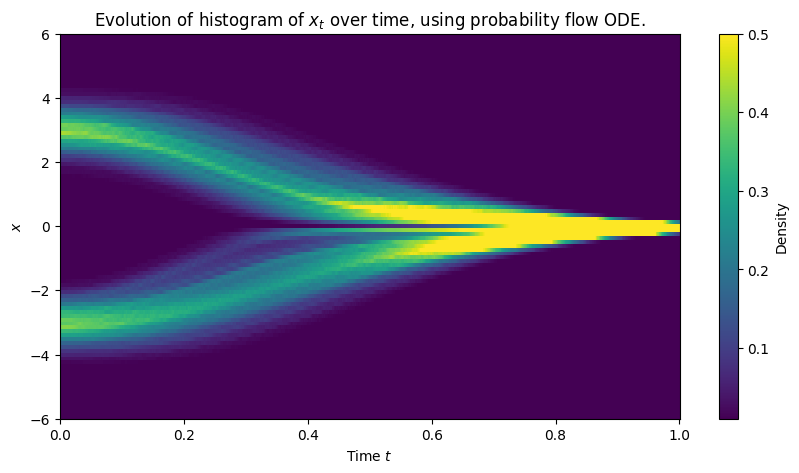

In [7]:
#part 1.4
#params
dt = 1e-3 
n_steps = 1000
T = n_steps * dt
time_points = np.linspace(0, T, n_steps + 1)
x0_ODE = q_sample(10000)
x = x0_ODE.clone()

x_all_ODE = torch.zeros(n_steps + 1, 10000, device=device)
x_all_ODE[0] = x.squeeze()
model.eval()
for step in range(1, n_steps + 1):
    t = (step - 1) * dt
    t_tensor = torch.full((10000, 1), t, device=device)

    with torch.no_grad():
        score = model(x, t_tensor)
        beta = bar_lin_t(t)
        drift = -0.5 * beta * (x + score)
        x = x + drift * dt
        x_all_ODE[step] = x.squeeze()
x_all_ODE = x_all_ODE.cpu().numpy()
x_bins = np.linspace(-6, 6, 100)
t_bins = np.linspace(0, T, n_steps + 1)
heatmap_ode = np.zeros((len(x_bins)-1, len(t_bins)))

for t_idx in range(len(t_bins)):
    hist, _ = np.histogram(x_all_ODE[t_idx], bins=x_bins, density=True)
    heatmap_ode[:, t_idx] = hist

# 4. Plot the heatmap
plt.figure(figsize=(10, 5))
X, Y = np.meshgrid(t_bins, 0.5 * (x_bins[:-1] + x_bins[1:]))
plt.pcolormesh(X, Y, heatmap_ode, shading='auto', cmap='viridis',vmin=1e-2, vmax=0.5)
plt.colorbar(label='Density')
plt.xlabel("Time $t$")
plt.ylabel("$x$")
plt.title("Evolution of histogram of $x_t$ over time, using probability flow ODE.")
plt.show()


## Part 1.5
5. Now, reverse the process by sampling 10,000 samples from the prior distribution and taking reverse steps according to the reverse SDE using the score. To sample using Euler in the reverse process, see equation 46 in the paper linked above (in Appendix E, $\mathbf{f}\equiv \mu, \mathbf{G}\equiv \sigma$). Display the trajectory of 2 random starting points using the reverse SDE.

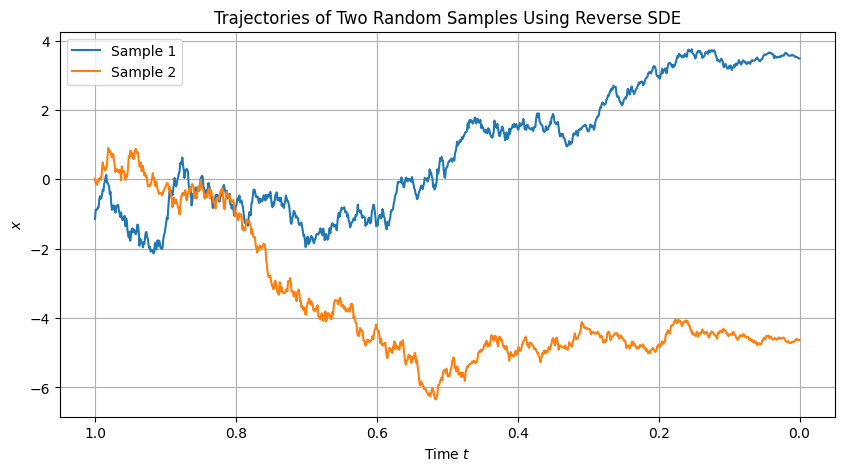

In [42]:
dt = 1e-3
n_steps = 1000
T = n_steps * dt

time_points = np.linspace(T, 0, n_steps + 1)
#start from prior N(0, I])
xT = torch.randn(10000, 1, device=device)
x = xT.clone()

x_all_reverse = torch.zeros(n_steps + 1, 10000, device=device)
x_all_reverse[0] = x.squeeze()

model.eval()
idx1, idx2 = np.random.choice(10000, 2, replace=False)
traj1, traj2 = [], []
traj1.append(x[idx1].item())
traj2.append(x[idx2].item())

for step in range(n_steps):
    t = time_points[step]
    t_tensor = torch.full((10000, 1), t, device=device)

    with torch.no_grad():
        score = model(x, t_tensor)
        beta = bar_lin_t(t) #this is beta func
        mu = -0.5 * beta * x
        reverse_drift = mu - beta * score
        diffusion = beta**0.5
        noise = torch.randn_like(x)

        x = x - reverse_drift * dt + diffusion * np.sqrt(dt) * noise
        x_all_reverse[step + 1] = x.squeeze()

        traj1.append(x[idx1].item())
        traj2.append(x[idx2].item())


x_all_reverse = x_all_reverse.cpu().numpy()
traj1 = np.array(traj1)
traj2 = np.array(traj2)

# Plot trajectories
plt.figure(figsize=(10, 5))
plt.plot(np.linspace(T, 0, n_steps + 1), traj1, label='Sample 1')
plt.plot(np.linspace(T, 0, n_steps + 1), traj2, label='Sample 2')
plt.xlabel("Time $t$")
plt.ylabel("$x$")
plt.title("Trajectories of Two Random Samples Using Reverse SDE")
plt.legend()
plt.grid(True)
plt.gca().invert_xaxis()
plt.show()


## Bonus

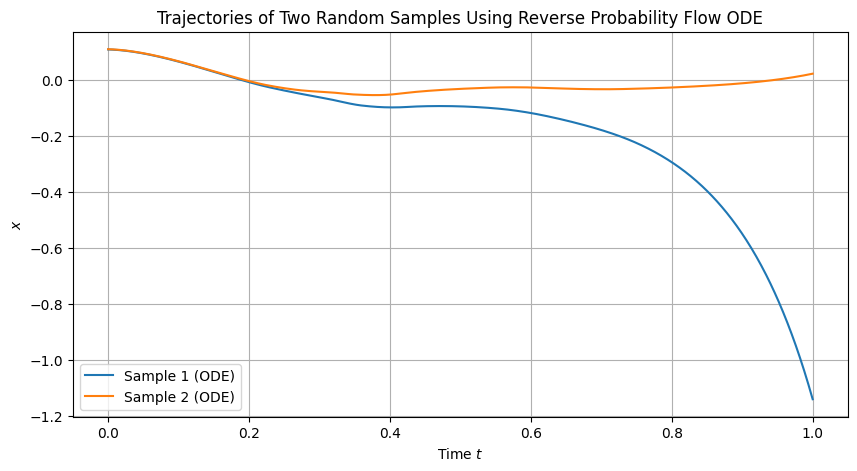

In [50]:
x_ode = xT.clone()
x_all_ode = torch.zeros(n_steps + 1, 10000, device=device)
x_all_ode[0] = x_ode.squeeze()

traj1_ode = [x_ode[idx1].item()]
traj2_ode = [x_ode[idx2].item()]

for step in range(n_steps):
    t = T - step * dt                # reverse time from T down to 0
    t_tensor = torch.full((10000, 1), t, device=device)

    with torch.no_grad():
        score = model(x_ode, t_tensor)      
        beta = bar_lin_t(t)             
        drift = -0.5 * beta * (x_ode + score)
        x_ode = x_ode + drift * dt     

    x_all_ode[step + 1] = x_ode.squeeze()
    traj1_ode.append(x_ode[idx1].item())
    traj2_ode.append(x_ode[idx2].item())

# Plot:
plt.figure(figsize=(10, 5))
plt.plot(np.linspace(T, 0, n_steps+1),
         traj1_ode, label='Sample 1 (ODE)')
plt.plot(np.linspace(T, 0, n_steps+1),
         traj2_ode, label='Sample 2 (ODE)')
plt.xlabel("Time $t$")
plt.ylabel("$x$")
plt.title("Trajectories of Two Random Samples Using Reverse Probability Flow ODE")
plt.legend()
plt.grid(True)
plt.show()


Display the histogram of $\mathbf{x}_t$ as a function of time using a heatmap on the $y$ axis. You can use meshgrids and `matplotlib`'s pcolormesh to display the histogram as shown below. There should be 3/4 total histograms:

1. Histogram of Euler discretization of forward SDE (100,000 starting points).
2. Histogram of Euler discretization of probability flow ODE (10,000 starting points). It's ok if the histogram isn't as nice as the SDE histogram, but points will still be deducted if it's very different in general behavior.
3. Histogram of Euler discretization of reverse SDE (10,000 starting points). It's ok if it isn't exactly the reverse of the forward SDE, but points will still be removed if there are mistakes in the code.
4. (Bonus) Histogram of Euler discretization of reverse probability flow ODE (10,000 starting points).

Expected outputs for first histogram:

![](attachment:image.png)

## Part 2: Implementing DDPM as a Score Network

This part (and all following parts) will require a GPU, so you should run it on the machines we provided.

Note that parts 2 and 3 should heavily rely on your existing DDPM code. Not much has to change.

In the recent tutorials, we showed how the training procedures for DDPM and ALD are actually equivalent, and that using a basic transformation, we can view a model trained according to the DDPM loss as a model that approximates the score. In this part we will show how this is true.
1. Train a DDPM model the same way you trained in HW2, using either MNIST from HW1 (recommended) or Fashion MNIST from HW2. The only difference should be that time ($t$) should be between 0 and 1 as opposed to 1 and $T$. Note that because the time is now of a different scale, we may need to use a different method for time encoding. For now, $\beta(t) = \beta_{t*T}$.
2. Fill in the function ```get_score_model``` that accepts a model that was trained according to the DDPM loss and returns a new model that approximates the score (note that this is a nested function, meaning it returns a function).
3. Sample from the model using the score model, using what we saw in tutorials 5/6 and the sampling method above, or using Ancestral Sampling (shown in Equation 4 in the paper linked in part 1 and in tutorial 4). Display 64 sampled images.

# part 2.1

In [10]:
import math
from inspect import isfunction
from functools import partial

%matplotlib inline
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from einops import rearrange

import torch
from torch import nn, einsum
import torch.nn.functional as F



def exists(x):
    return x is not None

def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d

class Residual(nn.Module):
    """
    simply adds the input to the output of a particular function
    """
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x

def Upsample(dim):
    return nn.ConvTranspose2d(dim, dim, 4, 2, 1)

def Downsample(dim):
    return nn.Conv2d(dim, dim, 4, 2, 1)



class SinusoidalPositionEmbeddings(nn.Module):
    """
    Sinusoidal position embeddings, as described in the paper
    """

    def __init__(self, dim):
        """
        :param dim: int, the dimension of the embeddings
        """
        super().__init__()
        self.dim = dim

    def forward(self, time):
        """
        :param time: torch Tenseor of shape (batch_size, 1)
        :return: torch Tensor of shape (batch_size, dim)
        """
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings



class Block(nn.Module):
    def __init__(self, dim, dim_out, groups = 8):
        super().__init__()
        self.proj = nn.Conv2d(dim, dim_out, 3, padding = 1)
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def forward(self, x, scale_shift = None):
        x = self.proj(x)
        x = self.norm(x)

        if exists(scale_shift):
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        x = self.act(x)
        return x

class ResnetBlock(nn.Module):

    def __init__(self, dim, dim_out, *, time_emb_dim=None, groups=8):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.SiLU(), nn.Linear(time_emb_dim, dim_out))
            if exists(time_emb_dim)
            else None
        )

        self.block1 = Block(dim, dim_out, groups=groups)
        self.block2 = Block(dim_out, dim_out, groups=groups)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        h = self.block1(x)

        if exists(self.mlp) and exists(time_emb):
            time_emb = self.mlp(time_emb)
            h = rearrange(time_emb, "b c -> b c 1 1") + h

        h = self.block2(h)
        return h + self.res_conv(x)



class Attention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )
        q = q * self.scale

        sim = einsum("b h d i, b h d j -> b h i j", q, k)
        sim = sim - sim.amax(dim=-1, keepdim=True).detach()
        attn = sim.softmax(dim=-1)

        out = einsum("b h i j, b h d j -> b h i d", attn, v)
        out = rearrange(out, "b h (x y) d -> b (h d) x y", x=h, y=w)
        return self.to_out(out)

class LinearAttention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)

        self.to_out = nn.Sequential(nn.Conv2d(hidden_dim, dim, 1),
                                    nn.GroupNorm(1, dim))

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )

        q = q.softmax(dim=-2)
        k = k.softmax(dim=-1)

        q = q * self.scale
        context = torch.einsum("b h d n, b h e n -> b h d e", k, v)

        out = torch.einsum("b h d e, b h d n -> b h e n", context, q)
        out = rearrange(out, "b h c (x y) -> b (h c) x y", h=self.heads, x=h, y=w)
        return self.to_out(out)





class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.GroupNorm(1, dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)



class Unet(nn.Module):
    """
    Unet architecture for diffusion models
    the network takes a batch of noisy images of shape (batch_size, num_channels, height, width)
    and a batch of noise levels of shape (batch_size, 1) as input
    and returns a tensor of shape (batch_size, num_channels, height, width)
    """
    def __init__(
        self,
        dim,
        init_dim=None,
        out_dim=None,
        dim_mults=(1, 2, 4, 8),
        channels=3,
        with_time_emb=True,
        resnet_block_groups=1
    ):
        super().__init__()
        #### ADD YOUR CODE HERE ####
        # input channels
        self.channels = channels
        # set initial dimension to default
        init_dim = default(init_dim, dim)
        # conv layer to proccess input data
        self.init_conv = nn.Conv2d(channels, init_dim, 7, padding=3)

        # dimension calculation for each layer (*map = unpacks the map the flat list)
        dimensions = [init_dim, *map(lambda m: dim * m, dim_mults)]

        # tuple of dimensions between each two input output layers
        input_output_dim = list(zip(dimensions[:-1], dimensions[1:]))

        # time embedding setup
        self.with_time_emb = with_time_emb
        if with_time_emb:
            time_dim = dim * 4
            # time embedding with mlp
            self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(dim),  # convert time to sinusoidal embeddings
                nn.Linear(dim, time_dim),           # higher dimension linear layer
                nn.GELU(),                          # activation function
                nn.Linear(time_dim, time_dim)
            )
        else:
            time_dim = None

        # Store dimensions for debugging

        # Each downsampling stage consists of 2 ResNet blocks + groupnorm + attention (optionally linear) + residual connection + a downsample operation
        self.downsample = nn.ModuleList([])
        for index, (dim_in, dim_out) in enumerate(input_output_dim):
            is_last_downsample = index == len(input_output_dim) - 1
            self.downsample.append(nn.ModuleList([
                # 1st ResNet block changes dim_in to dim_out
                ResnetBlock(dim_in, dim_out, time_emb_dim=time_dim, groups=resnet_block_groups),
                # 2nd ResNet block maintains new dimension
                ResnetBlock(dim_out, dim_out, time_emb_dim=time_dim, groups=resnet_block_groups),
                # groupnorm + attention (optionally linear) + residual connection
                Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                # downsample apart from the last layer
                Downsample(dim_out) if not is_last_downsample else nn.Identity()
            ]))

        # middle of the network -  ResNet blocks are applied, interleaved with attention
        mid_dim = dimensions[-1]
        self.mid_first_block = ResnetBlock(mid_dim, mid_dim, time_emb_dim=time_dim, groups=resnet_block_groups)
        self.mid_attention = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_second_block = ResnetBlock(mid_dim, mid_dim, time_emb_dim=time_dim, groups=resnet_block_groups)

        # upsampling - Each upsampling stage consists of 2 ResNet blocks + groupnorm + attention (optionally linear) + residual connection + an upsample operation
        self.upsample = nn.ModuleList([])
        for index, (dim_in, dim_out) in enumerate(reversed(input_output_dim)):
            is_last_upsample = index >= len(input_output_dim) - 1
            self.upsample.append(nn.ModuleList([
                # 1st ResNet block processes concatenated skip connection
                ResnetBlock(dim_out * 2, dim_in, time_emb_dim=time_dim, groups=resnet_block_groups),
                # 2nd ResNet block
                ResnetBlock(dim_in, dim_in, time_emb_dim=time_dim, groups=resnet_block_groups),
                # groupnorm + attention (optionally linear) + residual connection
                Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                # upsample apart from the last layer
                Upsample(dim_in) if not is_last_upsample else nn.Identity()
            ]))

        # finally, a ResNet block followed by a convolutional layer is applied.
        self.final_conv = nn.Sequential(
            ResnetBlock(dim, dim, time_emb_dim=time_dim),
            nn.Conv2d(dim, channels, 1)
        )
        #### DONE WITH SOLUTION ####

    def forward(self, x, time):
        """
        :param x: torch Tensor of shape (batch_size, channels, height, width)
        :param time: torch Tensor of shape (batch_size, 1)
        :return: torch Tensor of shape (batch_size, channels, height, width)
        """

        #### ADD YOUR CODE HERE ####
        x = self.init_conv(x)
        h = x
        
        # ensure time is a 1D tensor of shape (batch,)
        if time is not None and time.dim() == 2:
            time = time.squeeze(-1)  # (batch, 1) -> (batch,)
        
        # Process position embeddings for noise levels
        if self.with_time_emb and time is not None:
            t = self.time_mlp(time)      # might be (batch, 1, time_dim)
        else:
            t = None

        # skip connections
        h_skips = []

        # applying downsampling stages
        for resnet1, resnet2, attn, downsample in self.downsample:
            h = resnet1(h, t)
            h = resnet2(h, t)
            h = attn(h)
            h_skips.append(h)
            h = downsample(h)

        # applying middle blocks
        h = self.mid_first_block(h, t)
        h = self.mid_attention(h)
        h = self.mid_second_block(h, t)

        # applying upsampling stages
        for resnet1, resnet2, attn, upsample in self.upsample:
            skip = h_skips.pop()
            h = torch.cat((h, skip), dim=1)  #concat with skip connections
            h = resnet1(h, t)
            h = resnet2(h, t)
            h = attn(h)
            h = upsample(h)

        # applying final ResNet block and convolution
        h = self.final_conv(h)
        return h
        #### DONE WITH SOLUTION ####





def linear_beta_schedule(timesteps):
    """
    set the forward process variances to constants
    increasing linearly from beta_1 = 0.0001 to beta_T = 0.02.
    :param timesteps: int
    :return: torch Tensor of shape (timesteps,)
    """
    #### ADD YOUR CODE HERE ####
    beta_start = 0.0001
    beta_end = 0.02
    #### DONE WITH SOLUTION ####
    return torch.linspace(beta_start, beta_end, timesteps)
    

def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule ([Nichol et al., 2021](https://arxiv.org/abs/2102.09672))
    :param timesteps: int
    :param s: float
    :return: torch Tensor of shape (timesteps,)
    """
    #### ADD YOUR CODE HERE ####
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * math.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    #### DONE WITH SOLUTION ####
    return torch.clip(betas, 0.0001, 0.9999)



timesteps = 200

# define beta schedule
betas = linear_beta_schedule(timesteps=timesteps)


# define alphas
#### ADD YOUR CODE HERE ####
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
#### DONE WITH SOLUTION ####

# calculations for diffusion q(x_t | x_{t-1}) and others
#### ADD YOUR CODE HERE ####
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
#### DONE WITH SOLUTION ####

# calculations for posterior q(x_{t-1} | x_t, x_0)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

def extract(a, t, x_shape):
    # extracts the appropriate $t$ index for a batch of indices
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)


# forward diffusion q(x_t | x_0)
def q_sample(x_start, t, noise=None):
    """
    q_sample function for diffusion process
    :param x_start: torch Tensor of shape (batch_size, channels, height, width)
    :param t: torch Tensor of shape (batch_size, 1)
    :param noise: Optional(torch.Tensor) = None
    :return: torch Tensor of shape (batch_size, channels, height, width)
    """
    #### ADD YOUR CODE HERE ####
    if noise is None:
        noise = torch.randn_like(x_start)


    #extracting the right scaling factors for the sampling at timestep t
    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x_start.shape)

    #applying the forward diffusion process equation  q(x_t | x_0) = sqrt(alpha_cumprod_t) * x_0 + sqrt(1 - alpha_cumprod_t) * noise
    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise
    
    #### DONE WITH SOLUTION ##


def p_losses(denoise_model, x_start, t, noise=None, loss_type="l1"):
    if noise is None:
        noise = torch.randn_like(x_start)

    #### ADD YOUR CODE HERE ####
    x_noise = q_sample(x_start,t,noise = noise)
    predicted_noise = denoise_model(x_noise,t)
    ### DONE WITH SOLUTION ####

    if loss_type == 'l1':
        loss = F.l1_loss(noise, predicted_noise)
    elif loss_type == 'l2':
        loss = F.mse_loss(noise, predicted_noise)
    else:
        raise NotImplementedError()

    return loss


from datasets import load_dataset
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

#### ADD YOUR CODE HERE ####
transform = transforms.Compose([
            transforms.ToTensor(), #converting to tensor and scaleing to [0, 1]
            transforms.Lambda(lambda t: (t*2) - 1) #scaling to [-1, 1]
        ])

class FashionMNISTDataset(Dataset):
    """
    Dataset class for Fashion-MNIST dataset
    """
    def __init__(self,split='train',transform = None):
        """
        Initialize the dataset
        :param split: str, either "train" or "test"
        """
        self.data = load_dataset("fashion_mnist", split=split)
        self.transform = transform
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        """
        Return the item at index idx
        :param idx: int, index of the item to return
        :return: torch.Tensor of shape (1, 28, 28), the image scaled to [-1, 1]
        
        """
        image = self.data[idx]["image"]
        image = self.transform(image)
        
        return image
#datasets creation
batch_size = 64
dataset = FashionMNISTDataset(split='train+test', transform=transform)
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
#### DONE WITH SOLUTION ####


@torch.no_grad()
def p_sample(model, x, t, t_index):
    """
    p_sample function for reverse process
    :param model: torch.nn.Module
    :param x: torch Tensor of shape (batch_size, channels, height, width)
    :param t: torch Tensor of shape (batch_size,)
    :param t_index: int
    :return: torch Tensor of shape (batch_size, channels, height, width)
    """
    #model prediction
    predicted_noise = model(x, t)
    
    #parameters needed for the sampling formula
    beta_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x.shape)
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)
    
    #mean of the posterior distribution
    model_mean = sqrt_recip_alphas_t * (x - beta_t * predicted_noise / sqrt_one_minus_alphas_cumprod_t)
    
    #for the final timestep, return only the mean
    if t_index == 0:
        return model_mean
    else:
        sigma_t = torch.sqrt(beta_t)
        noise = torch.randn_like(x)
        return model_mean + sigma_t * noise
        #### DONE WITH SOLUTION ####


# Algorithm 2 but save all images:
@torch.no_grad()
def p_sample_loop(model, shape):
    device = next(model.parameters()).device

    b = shape[0]
    # start from pure noise (for each example in the batch)
    img = torch.randn(shape, device=device)
    imgs = []

    for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
        img = p_sample(model, img, torch.full((b,), i, device=device, dtype=torch.long), i)
        imgs.append(img.cpu().numpy())
    return imgs

@torch.no_grad()
def sample(model, image_size, batch_size=16, channels=3):
    return p_sample_loop(model, shape=(batch_size, channels, image_size, image_size))




from torch.optim import Adam
#changed

device = "cuda" if torch.cuda.is_available() else "cpu"
channels = 1
image_size = 32

model = Unet(
    dim=image_size,
    channels=channels,
    dim_mults=(1, 2, 4,)
)
model.to(device)
optimizer = Adam(model.parameters(), lr=1e-4,weight_decay=1e-6)


README.md:   0%|          | 0.00/9.02k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/30.9M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/5.18M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [11]:
from torchvision.utils import save_image
from pathlib import Path

#### ADD YOUR CODE HERE ####
from tqdm.auto import tqdm
import numpy as np
import random
import torch


timesteps = 1000
# define beta schedule
betas = linear_beta_schedule(timesteps=timesteps)
alphas = 1.0 - betas

# alpha_bar_t
alphas_cumprod = torch.cumprod(alphas, dim=0)

# alpha_bar_t-1, with alpha_0 = 1
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1. / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

# calculations for posterior q(x_{t-1} | x_t, x_0)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

# reproducibility
seed_num = 826
torch.manual_seed(seed_num)
np.random.seed(seed_num)
random.seed(seed_num)

# CUDA support
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# save samples on Kaggle
model_folder = Path("/kaggle/working/samples")
model_folder.mkdir(parents=True, exist_ok=True)

epochs = 20

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    for step, batch in enumerate(train_dataloader):
        model.train()
        optimizer.zero_grad()
        x_start = batch.to(device)
        t = torch.randint(0, timesteps, (x_start.shape[0],), device=device)
        loss = p_losses(model, x_start, t, loss_type="l2")
        loss.backward()
        optimizer.step()

        if step % 100 == 0:
            percent = (step + 1) / len(train_dataloader) * 100
            print(f"Step {step+1}/{len(train_dataloader)} ({percent:.2f}%) - Loss: {loss.item():.4f}")

    # save model checkpoint (overwrite if desired)
    model_path = model_folder / f"model_unet_latest_30_epochs_{seed_num}.pth"
    torch.save(model.state_dict(), model_path)
#### DONE WITH SOLUTION ####        



Epoch 1/20
Step 1/1094 (0.09%) - Loss: 1.2408
Step 101/1094 (9.23%) - Loss: 0.1927
Step 201/1094 (18.37%) - Loss: 0.1397
Step 301/1094 (27.51%) - Loss: 0.1289
Step 401/1094 (36.65%) - Loss: 0.0730
Step 501/1094 (45.80%) - Loss: 0.0669
Step 601/1094 (54.94%) - Loss: 0.0648
Step 701/1094 (64.08%) - Loss: 0.0878
Step 801/1094 (73.22%) - Loss: 0.0788
Step 901/1094 (82.36%) - Loss: 0.1055
Step 1001/1094 (91.50%) - Loss: 0.0709
Epoch 2/20
Step 1/1094 (0.09%) - Loss: 0.0715
Step 101/1094 (9.23%) - Loss: 0.0616
Step 201/1094 (18.37%) - Loss: 0.0459
Step 301/1094 (27.51%) - Loss: 0.0588
Step 401/1094 (36.65%) - Loss: 0.0722
Step 501/1094 (45.80%) - Loss: 0.0887
Step 601/1094 (54.94%) - Loss: 0.0515
Step 701/1094 (64.08%) - Loss: 0.0749
Step 801/1094 (73.22%) - Loss: 0.0504
Step 901/1094 (82.36%) - Loss: 0.0652
Step 1001/1094 (91.50%) - Loss: 0.0483
Epoch 3/20
Step 1/1094 (0.09%) - Loss: 0.0600
Step 101/1094 (9.23%) - Loss: 0.0732
Step 201/1094 (18.37%) - Loss: 0.0599
Step 301/1094 (27.51%) - Lo

In [12]:
# sample 64 images
samples = sample(model, image_size=image_size, batch_size=64, channels=channels)

#### ADD YOUR CODE HERE ####
import os
import zipfile
from pathlib import Path
import numpy as np
from PIL import Image

assignment_number = 2
student_id = "318280294"

# 1. Sample images
final_samples = samples[-1]
img_dir = Path("generated_images")
img_dir.mkdir(exist_ok=True)

# 3. Save each image as PNG
for i, img in enumerate(final_samples):
    # Convert from [-1,1] to [0,255] uint8
    if img.shape[0] == 1:
        array = ((img[0] + 1) / 2 * 255).astype(np.uint8)
        pil_img = Image.fromarray(array, mode="L")
    else:
        array = ((np.transpose(img, (1, 2, 0)) + 1) / 2 * 255).astype(np.uint8)
        pil_img = Image.fromarray(array)
    pil_img.save(img_dir / f"sample_{i:02d}.png")

# # 4. Create ZIP for submission
# zip_name = f"HW{assignment_number}_{student_id}.zip"
# with zipfile.ZipFile(zip_name, "w") as zf:
#     for img_path in sorted(img_dir.iterdir()):
#         zf.write(img_path, arcname=img_path.name)

# print(f"Saved 64 images to '{img_dir}/' and created submission ZIP '{zip_name}'")

#### DONE WITH SOLUTION ####

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

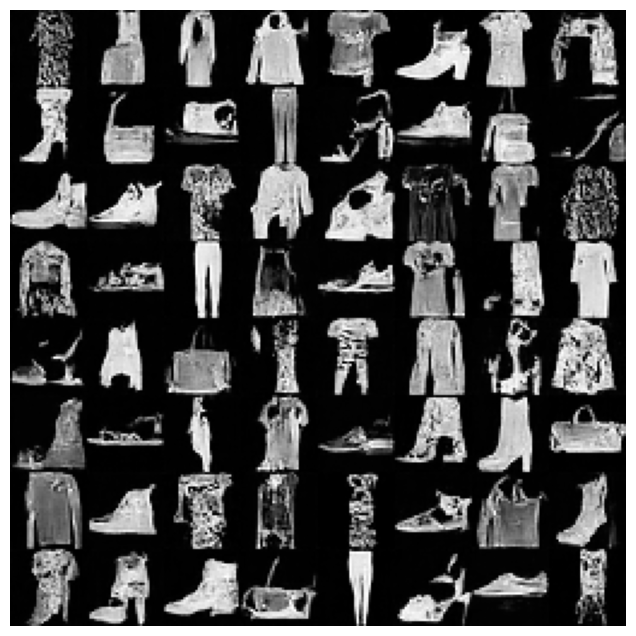

In [13]:
#Creating grid of all images
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision.utils import make_grid
from torchvision.transforms.functional import to_pil_image

final_images = samples[-1]  # shape: [64, 1, H, W] if grayscale

# Convert to tensor and rescale from [-1, 1] to [0, 1]
final_images = torch.tensor(final_images)
final_images = (final_images + 1) / 2
final_images = final_images.clamp(0, 1)

# Create a grid of images with no padding
grid_img = make_grid(final_images, nrow=8, padding=0)  # shape: [1, H_total, W_total]

# Plot the grid
plt.figure(figsize=(8, 8))
plt.imshow(grid_img.permute(1, 2, 0).squeeze(), cmap='gray')  # permute to [H, W, C]
plt.axis("off")
plt.show()

## part 2.2
Fill in the function get_score_model that accepts a model that was trained according to the DDPM loss and returns a new model that approximates the score (note that this is a nested function, meaning it returns a function).

In [14]:
def get_score_model(ddpm_model, ddpm_sqrt_1m_alpha):
    ddpm_model.eval()  # make sure it’s in eval mode
    @torch.no_grad()
    def score_fn(x, t):
        """
        x: Tensor (B, C, H, W)
        t: LongTensor (B,)
        """
        eps_pred = ddpm_model(x, t)
        sigma_t = extract(ddpm_sqrt_1m_alpha, t, x.shape)
        return -eps_pred / sigma_t
    return score_fn

## part 2.3
Sample from the model using the score model, using what we saw in tutorials 5/6 and the sampling method above, or using Ancestral Sampling (shown in Equation 4 in the paper linked in part 1 and in tutorial 4). Display 64 sampled images.

Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

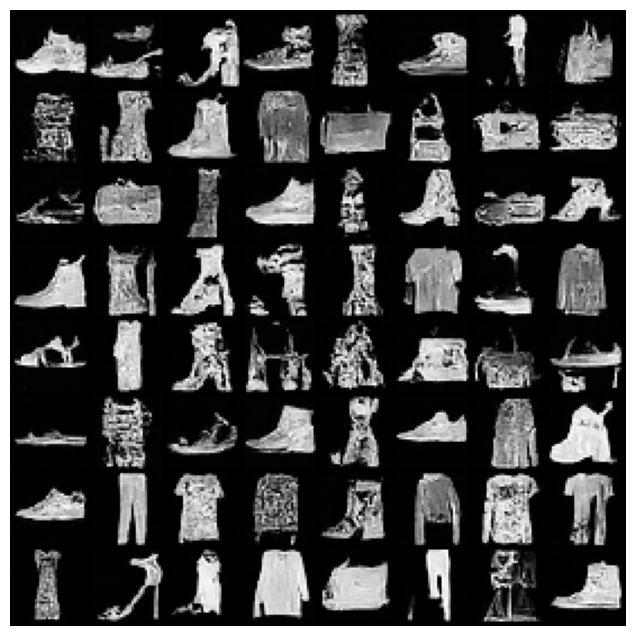

In [15]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

def extract(a, t, x_shape):
    batch = t.shape[0]
    out   = a.gather(0, t)                 # (B,)
    return out.view(batch, *([1] * (len(x_shape) - 1)))

# 2. Send model & schedules to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model      = model.to(device)
betas      = betas.to(device)
ddpm_sqrt_1m_alpha = sqrt_one_minus_alphas_cumprod.clone()
ddpm_sqrt_1m_alpha             = ddpm_sqrt_1m_alpha.to(device)
sqrt_one_minus_alphas_cumprod  = sqrt_one_minus_alphas_cumprod.to(device)
sqrt_recip_alphas              = sqrt_recip_alphas.to(device)

score_fn = get_score_model(model, ddpm_sqrt_1m_alpha)

@torch.no_grad()
def p_sample_score(x, t, t_index):
    s       = score_fn(x, t)                          
    sigma_t = extract(ddpm_sqrt_1m_alpha, t, x.shape) 
    eps_pred= - sigma_t * s                              

    b_t  = extract(betas, t, x.shape)
    a1   = extract(sqrt_one_minus_alphas_cumprod, t, x.shape)
    a0   = extract(sqrt_recip_alphas, t, x.shape)

    mean = a0 * (x - b_t * eps_pred / a1)
    if t_index == 0:
        return mean
    return mean + torch.sqrt(b_t) * torch.randn_like(x)

@torch.no_grad()
def sample_score(n_samples=64):
    x = torch.randn((n_samples, channels, image_size, image_size), device=device)
    for i in tqdm(range(timesteps-1, -1, -1), total=timesteps, desc="Sampling"):
        t = torch.full((n_samples,), i, device=device, dtype=torch.long)
        x = p_sample_score(x, t, i)
    return (x + 1) * 0.5  # denormalize to [0,1]

samples = sample_score(64)
grid    = make_grid(samples, nrow=8)

plt.figure(figsize=(8,8))
plt.axis('off')
plt.imshow(grid.permute(1,2,0).cpu(), cmap='gray')
plt.show()


## Part 3: True SDE Implementation

## part 3.1 and 3.2
Fill in the classes DDPM_SDE, UnifiedLoss. For the loss, you can either use the score matching loss (less recommended) or the regular noise matching loss. If you use the noise matching loss, implement a function get_score_model_continuous(model, sde) that transforms your model that approximates noise to a model that approximates the score. Remember that for , we may have a problem defining the std=0, so we can define a small std instead. Implement train_sde.

Fill in the class AncestralSamplingContinuous. This class can either sample using what we saw in part 2 or using Euler's method on the reverse DDPM SDE as implemented in part 1. Implement sample_images which should denoise images. Note that the final sampling step should add 0 noise.

In [16]:
class DDPM_SDE:
    def __init__(self, beta_min, beta_max, T_discrete, device):
        # Scale for continuous formulation: beta(t) = T * beta_discrete
        self.beta_min = beta_min * T_discrete
        self.beta_max = beta_max * T_discrete
        self.T_discrete = T_discrete
        self.device = device

    def beta(self, t):
        return self.beta_min + t * (self.beta_max - self.beta_min)

    def alpha_bar(self, t): 
        return torch.exp(-self.beta_min * t - 0.5 * (self.beta_max - self.beta_min) * t ** 2)

    def distribution(self, x_0, t):
        """Forward diffusion q(x_t | x_0) ~ N(mean, std^2)"""
        alpha_bar_t = self.alpha_bar(t).view(-1, 1, 1, 1)
        mean = alpha_bar_t.sqrt() * x_0
        std = torch.sqrt(1. - alpha_bar_t).clamp(min=1e-5)
        return mean, std

    def drift_diffusion(self, x_t, t):
        """Forward SDE: dx = -0.5 * beta(t) * x dt + sqrt(beta(t)) dW"""
        beta_t = self.beta(t).view(-1, 1, 1, 1)
        drift = -0.5 * beta_t * x_t
        diffusion = torch.sqrt(beta_t)
        return drift, diffusion

    def reverse_drift_diffusion(self, score_fn, x_t, t):
        """Reverse SDE: dx = [ -0.5 beta x - beta * gradiant log p ] dt + sqrt(beta) dW """
        beta_t = self.beta(t).view(-1, 1, 1, 1)
        drift = -0.5 * beta_t * x_t - beta_t * score_fn(x_t, t)
        diffusion = torch.sqrt(beta_t)
        return drift, diffusion

class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        """
        :param time: Tensor of shape (B,) or (B, 1), assumed to be ∈ [0, 1]
        :return: Tensor of shape (B, dim)
        """
        if time.dim() == 2 and time.shape[1] == 1:
            time = time.squeeze(-1)  # (B,)

        device = time.device
        half_dim = self.dim // 2
        emb_scale = math.log(10000) / (half_dim - 1)
        freqs = torch.exp(torch.arange(half_dim, device=device) * -emb_scale)
        args = time[:, None] * freqs[None, :]  # (B, half_dim)

        emb = torch.cat([args.sin(), args.cos()], dim=-1)  # (B, dim)
        return emb


def get_score_model_continuous(noise_model, sde: DDPM_SDE):
    """
    Converts a noise prediction model ε_θ to a score function: ∇ log p(x_t | t)
    """
    def score_fn(x_t, t):
        t_input = t.view(-1, 1)
        with torch.no_grad():
            noise_pred = noise_model(x_t, t_input)
        _, std = sde.distribution(torch.zeros_like(x_t), t)
        score = -noise_pred / std
        return score

    return score_fn
    
class UnifiedLoss(nn.Module):
    def __init__(self, sde, model):
        super().__init__()
        self.sde = sde
        self.model = model

    def forward(self, x):
        batch_size = x.size(0)
        device = x.device
        t = torch.rand(batch_size, device=device)
        mean, std = self.sde.distribution(x, t)
        std = torch.clamp(std, min=1e-8)
        noise = torch.randn_like(x)
        x_t = mean + std * noise
        t_input = t.view(-1, 1)
        pred_noise = self.model(x_t, t_input)
        return F.mse_loss(pred_noise, noise)

class AncestralSamplingContinuous(nn.Module):
    def __init__(self, sde, model):
        super().__init__()
        self.sde = sde
        self.score_fn = get_score_model_continuous(model, sde)

    def forward(self, x_T):
        dt = 1.0 / self.sde.T_discrete
        x = x_T
        all_images = []

        for step in range(self.sde.T_discrete):
            t_normalized = 1.0 - step / self.sde.T_discrete
            t_tensor = torch.full((x.shape[0],), t_normalized, device=x.device)

            drift, diffusion = self.sde.reverse_drift_diffusion(self.score_fn, x, t_tensor)
            noise = torch.randn_like(x) if step < self.sde.T_discrete - 1 else 0.0
            x = x + drift * (-dt) + diffusion * np.sqrt(dt) * noise

            if step % 100 == 0 or step == self.sde.T_discrete - 1:
                all_images.append(x.detach().cpu())

        return all_images

        return samples

def train_sde():
    """
    Trains the model using the UnifiedLoss.
    Uses gradient clipping with clip_grad_norm_ to stabilize training.
    """
    from torch.utils.data import DataLoader
    from torch.optim import Adam
    from torch.nn.utils import clip_grad_norm_

    dataset = FashionMNISTDataset(split='train+test', transform=transform)
    dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = Unet(dim=32, channels=1, dim_mults=(1, 2, 4)).to(device)
    optimizer = Adam(model.parameters(), lr=1e-4)
    sde = DDPM_SDE(beta_min=1e-4, beta_max=0.02, T_discrete=1000, device=device)
    loss_fn = UnifiedLoss(sde, model)

    for epoch in range(20):
        model.train()
        for x in dataloader:
            x = x.to(device)
            loss = loss_fn(x)
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
        print(f"Epoch {epoch+1}: Loss = {loss.item():.4f}")

    torch.save({"model": model.state_dict()}, "model.pth")
train_sde()

Epoch 1: Loss = 0.1117
Epoch 2: Loss = 0.0446
Epoch 3: Loss = 0.0631
Epoch 4: Loss = 0.0440
Epoch 5: Loss = 0.0507
Epoch 6: Loss = 0.0427
Epoch 7: Loss = 0.0348
Epoch 8: Loss = 0.0553
Epoch 9: Loss = 0.0389
Epoch 10: Loss = 0.0314
Epoch 11: Loss = 0.0321
Epoch 12: Loss = 0.0555
Epoch 13: Loss = 0.0659
Epoch 14: Loss = 0.0610
Epoch 15: Loss = 0.0353
Epoch 16: Loss = 0.0509
Epoch 17: Loss = 0.0637
Epoch 18: Loss = 0.0452
Epoch 19: Loss = 0.0301
Epoch 20: Loss = 0.0384


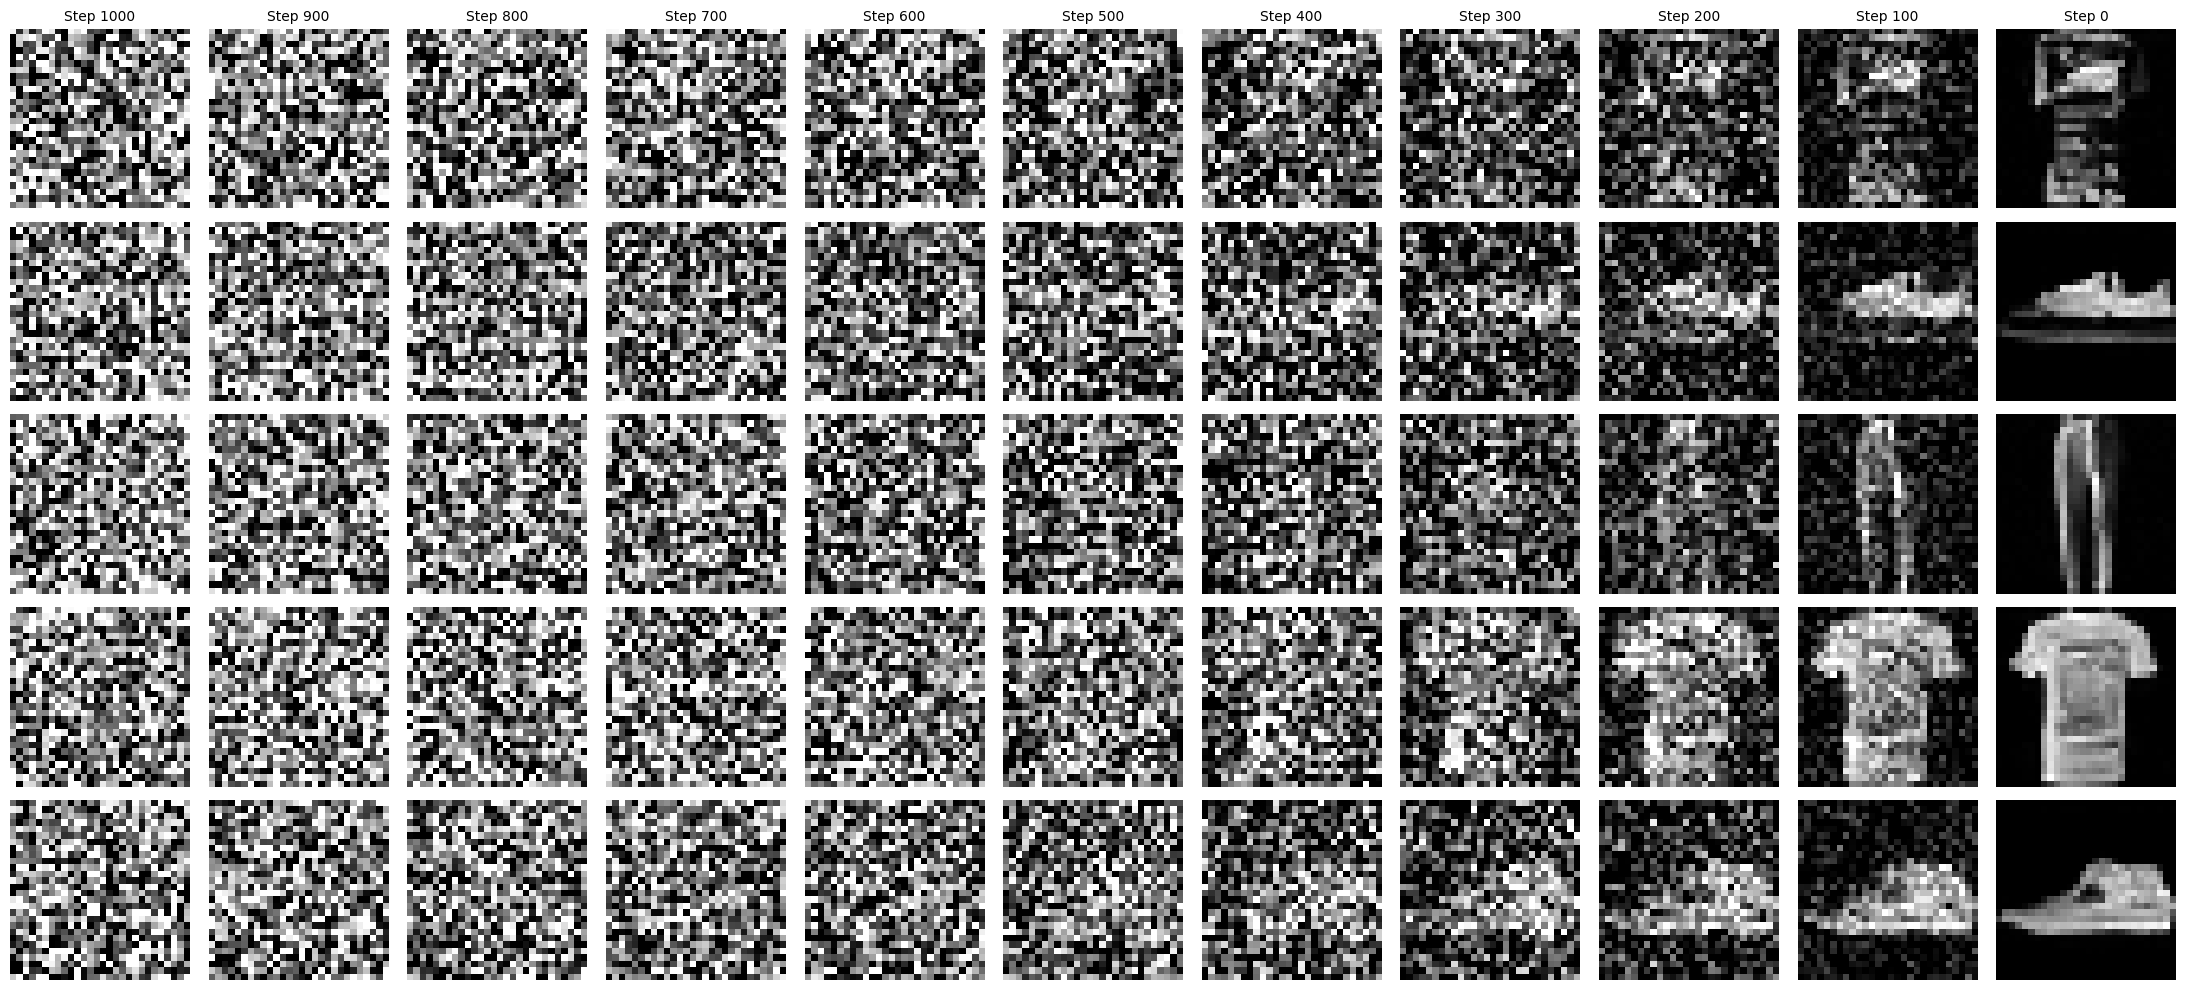

In [46]:
def sample_images():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    noise_model = Unet(dim=32, channels=1, dim_mults=(1, 2, 4)).to(device)
    ckpt = torch.load("model.pth", map_location=device)
    noise_model.load_state_dict(ckpt["model"])
    noise_model.eval()

    sde = DDPM_SDE(beta_min=1e-4, beta_max=0.02, T_discrete=1000, device=device)
    score_fn = get_score_model_continuous(noise_model=noise_model, sde=sde)

    sampler = AncestralSamplingContinuous(sde, noise_model).to(device)

    batch_size = 64
    with torch.no_grad():
        x_T = torch.randn(batch_size, 1, 28, 28, device=device)
        snapshots = sampler(x_T) 
    np.random.seed(42)
    chosen = np.random.choice(64, size=5, replace=False).tolist()
    # chosen might be e.g. [12, 37, 4, 55, 23]

    # 6) Prepare a 5×11 matplotlib grid. Each row = one of the 5 chosen samples.
    n_cols = len(snapshots)   # =11
    n_rows = len(chosen)      # =5

    plt.figure(figsize=(2.0 * n_cols, 2.0 * n_rows))
    for row, idx in enumerate(chosen):
        for col, snap in enumerate(snapshots):
            img = snap[idx].cpu().squeeze(0)  # shape = (28,28), values ~[-1,1]
            img = (img + 1.0) / 2.0           # rescale to [0,1]
            ax = plt.subplot(n_rows, n_cols, row * n_cols + col + 1)
            ax.imshow(img, cmap="gray", vmin=0, vmax=1)
            ax.axis("off")

            # Only label the top row with the step number:
            if row == 0:
                step_number = 1000 - 100 * col  # 1000, 900, 800, …, 100, 0
                ax.set_title(f"Step {step_number}", fontsize=10)

    plt.tight_layout()
    plt.show()
sample_images()

## Part 4: Conditional Generation

In this part, we will use the model we already trained along with a classifier to generate images that are conditioned on a certain class. Specifically, if we are using MNIST we will generate images of the number 5 and if we are using Fashion MNIST we will generate images of sandals (label 5). Note that the training in this section shouldn't take much time as we are using relatively simple datasets, and we are not training a new score model.

For help in this part, we refer you to the variety of open source implementations of this architecture.

1. Train a CNN classifier on your chosen dataset, noising the images according to the SDE to help the model deal with the noisy images that it will receive in generation. The classifier should reach at least 90% accuracy on the test set without noise (and in reality should reach even 98%+). You can choose to either implement $p_t(y|x)$ or just $p(y|x)$ (time can be an input to the CNN if you wish, not necessary for good enough results).
2. Use the score model from part 3 along with the classifier to sample images using classifier guidance. Sample using the same method of sampling that you chose in part 3, replacing the original score with the new "score". Play with the hyperparameter $\gamma$ (at least 3 different positive values) and briefly explain how different values of $\gamma$ influence the generated images. Generate 64 conditional images for each $\gamma$.
3. For the largest $\gamma$ you choose, run the classifier that you trained on the 64 images you generated. You should reach at least 70% accuracy on these images (meaning the classifier guidance should generate a majority of images that look like the correct class).

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import numpy as np


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate exactly the same SDE you used for score training:
sde = DDPM_SDE(beta_min=1e-4, beta_max=0.02, T_discrete=1000, device=device)


In [19]:
class NoisyFashionMNIST(Dataset):
    def __init__(self, train: bool, sde: DDPM_SDE):
        self.sde = sde
        base_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))  # scale images to ~[-1,1]
        ])
        self.dataset = datasets.FashionMNIST(
            root="./data",
            train=train,
            download=True,
            transform=base_transform
        )

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        x0, y = self.dataset[idx]  # x0 ∈ [-1,1], shape=(1,28,28)
        # Sample t ∼ Uniform(0,1)
        t = torch.rand(1, device=x0.device)  # shape=(1,)
        # Compute forward distribution at time t:
        mean, std = self.sde.distribution(x0.unsqueeze(0), t)  # mean/std shape=(1,1,28,28)
        std = std.clamp(min=1e-6)
        noise = torch.randn_like(mean)
        x_t = mean + std * noise  # shape=(1,1,28,28)
        x_t = x_t.squeeze(0)       # shape=(1,28,28)
        return x_t, t, y


In [20]:
class SinusoidalTimeEmbedding(nn.Module):
    def __init__(self, dim=16):
        super().__init__()
        half = dim // 2
        inv_freq = 1.0 / (10000 ** (torch.arange(0, half, 1) / half))
        self.register_buffer("inv_freq", inv_freq)

    def forward(self, t):
        # t: shape=(B,1) with values in [0,1]
        args = t * self.inv_freq  # shape=(B,half)
        emb = torch.cat([torch.sin(args), torch.cos(args)], dim=-1)  # (B,dim)
        return emb


class NoisyCNNClassifier(nn.Module):
    def __init__(self, time_embedding_dim=16, num_classes=10):
        super().__init__()
        # A simple 3‐layer convnet
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)  # (B,32,28,28)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1) # (B,64,28,28)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)# (B,128,28,28)
        self.pool = nn.MaxPool2d(2, 2)               # downsamples to 14×14 then 7×7

        # After conv3+pool twice: feature map = (B,128,7,7) → flatten=128*7*7=6272
        hidden_dim = 512
        self.time_embed = SinusoidalTimeEmbedding(dim=time_embedding_dim)
        self.fc1 = nn.Linear(6272 + time_embedding_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x_t, t):
        """
        x_t: (B,1,28,28), t: (B,1) in [0,1]
        returns logits over 10 classes
        """
        B = x_t.shape[0]
        h = F.relu(self.conv1(x_t))   # (B,32,28,28)
        h = self.pool(h)              # (B,32,14,14)
        h = F.relu(self.conv2(h))     # (B,64,14,14)
        h = self.pool(h)              # (B,64,7,7)
        h = F.relu(self.conv3(h))     # (B,128,7,7)
        h = h.view(B, -1)             # (B,6272)

        # time embedding
        temb = self.time_embed(t)     # (B, time_embedding_dim)

        h = torch.cat([h, temb], dim=1)  # (B,6272+time_emb_dim)
        h = F.relu(self.fc1(h))          # (B,hidden_dim)
        logits = self.fc2(h)             # (B,10)
        return logits

In [21]:
# Prepare datasets + dataloaders
train_ds = NoisyFashionMNIST(train=True, sde=sde)
test_ds  = NoisyFashionMNIST(train=False, sde=sde)
train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_ds,  batch_size=256, shuffle=False, num_workers=2)

# For “clean accuracy”, we need a dataset that returns (x0, y) with t=0. We can reuse FashionMNIST directly.
clean_test_ds = datasets.FashionMNIST(
    root="./data",
    train=False,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
)
clean_test_loader = DataLoader(clean_test_ds, batch_size=256, shuffle=False, num_workers=2)

# Instantiate model, optimizer, loss
classifier = NoisyCNNClassifier(time_embedding_dim=16, num_classes=10).to(device)
optimizer = optim.Adam(classifier.parameters(), lr=2e-4)
criterion = nn.CrossEntropyLoss()

# Training
n_epochs = 15
for epoch in range(n_epochs):
    classifier.train()
    running_loss = 0.0
    for x_t, t, y in train_loader:
        x_t, t, y = x_t.to(device), t.to(device), y.to(device)
        logits = classifier(x_t, t)              # (B,10)
        loss = criterion(logits, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * x_t.size(0)

    # One pass done → evaluate
    classifier.eval()
    # 1) Noisy test‐time accuracy
    correct_noisy = 0
    total_noisy = 0
    with torch.no_grad():
        for x_t, t, y in test_loader:
            x_t, t, y = x_t.to(device), t.to(device), y.to(device)
            logits = classifier(x_t, t)
            preds = logits.argmax(dim=1)
            correct_noisy += (preds == y).sum().item()
            total_noisy += y.size(0)

    # 2) Clean test‐time accuracy (force t=0)
    correct_clean = 0
    total_clean = 0
    with torch.no_grad():
        for x0, y in clean_test_loader:
            x0, y = x0.to(device), y.to(device)
            t0 = torch.zeros(x0.size(0), 1, device=device)  # t=0
            logits = classifier(x0, t0)
            preds = logits.argmax(dim=1)
            correct_clean += (preds == y).sum().item()
            total_clean += y.size(0)

    acc_noisy = correct_noisy / total_noisy
    acc_clean = correct_clean / total_clean
    print(f"Epoch {epoch+1}/{n_epochs}  "
          f"Loss={running_loss/len(train_ds):.4f}  "
          f"NoisyAcc={acc_noisy:.4f}  CleanAcc={acc_clean:.4f}")

# By the end, CleanAcc should be ≥0.98, NoisyAcc typically ≥0.90 if noise‐augmentation worked well.
# Save classifier
torch.save(classifier.state_dict(), "fashionmnist_classifier.pth")


100%|██████████| 26.4M/26.4M [00:00<00:00, 114MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 3.85MB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 45.7MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 14.3MB/s]


Epoch 1/15  Loss=1.5014  NoisyAcc=0.4798  CleanAcc=0.7584
Epoch 2/15  Loss=1.3655  NoisyAcc=0.4997  CleanAcc=0.7858
Epoch 3/15  Loss=1.3342  NoisyAcc=0.5139  CleanAcc=0.8125
Epoch 4/15  Loss=1.3136  NoisyAcc=0.5141  CleanAcc=0.8364
Epoch 5/15  Loss=1.3030  NoisyAcc=0.5126  CleanAcc=0.8385
Epoch 6/15  Loss=1.2919  NoisyAcc=0.5232  CleanAcc=0.8475
Epoch 7/15  Loss=1.2815  NoisyAcc=0.5247  CleanAcc=0.8527
Epoch 8/15  Loss=1.2822  NoisyAcc=0.5223  CleanAcc=0.8612
Epoch 9/15  Loss=1.2768  NoisyAcc=0.5293  CleanAcc=0.8577
Epoch 10/15  Loss=1.2722  NoisyAcc=0.5339  CleanAcc=0.8637
Epoch 11/15  Loss=1.2646  NoisyAcc=0.5181  CleanAcc=0.8607
Epoch 12/15  Loss=1.2608  NoisyAcc=0.5297  CleanAcc=0.8669
Epoch 13/15  Loss=1.2611  NoisyAcc=0.5305  CleanAcc=0.8695
Epoch 14/15  Loss=1.2557  NoisyAcc=0.5260  CleanAcc=0.8730
Epoch 15/15  Loss=1.2544  NoisyAcc=0.5288  CleanAcc=0.8689


Sampling with γ=0.5 …


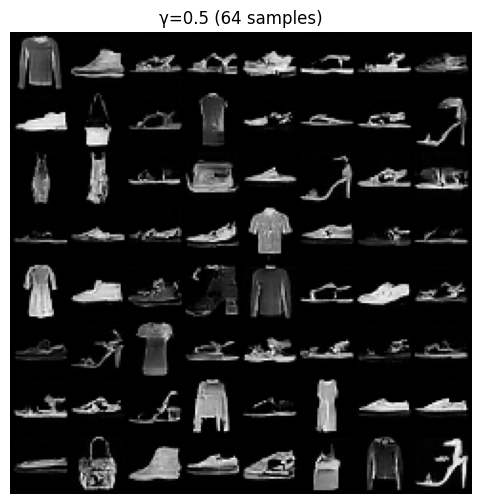

Sampling with γ=1.0 …


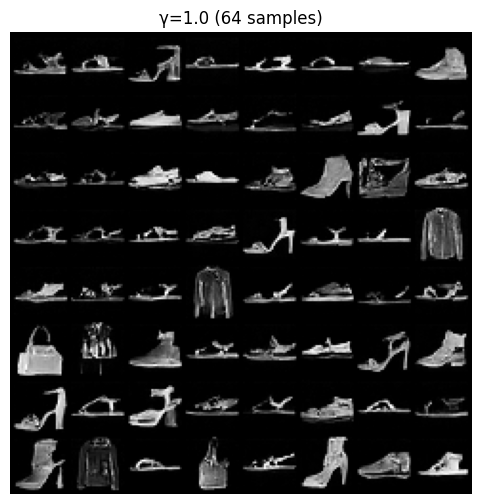

Sampling with γ=2.0 …


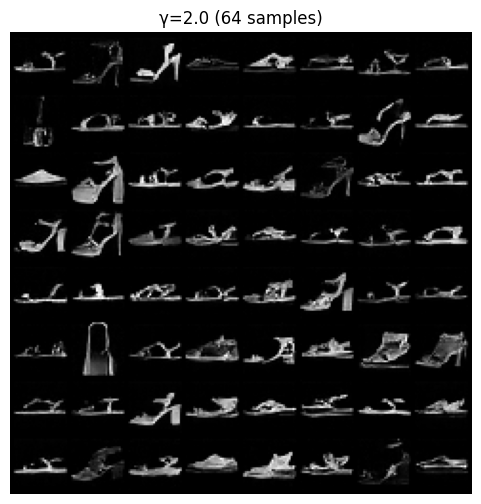

In [22]:
import math
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

# ——— Assume Unet, DDPM_SDE, get_score_model_continuous, and NoisyCNNClassifier are already defined/imported ———

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sde = DDPM_SDE(beta_min=1e-4, beta_max=0.02, T_discrete=1000, device=device)

# ——— Load pretrained noise‐prediction U-Net and convert to score_fn ———
noise_model = Unet(dim=32, channels=1, dim_mults=(1, 2, 4)).to(device)
ckpt = torch.load("model.pth", map_location=device)
noise_model.load_state_dict(ckpt["model"])
noise_model.eval()

score_fn = get_score_model_continuous(noise_model=noise_model, sde=sde)

# ——— Load pretrained classifier ———
classifier = NoisyCNNClassifier(time_embedding_dim=16, num_classes=10).to(device)
classifier.load_state_dict(torch.load("fashionmnist_classifier.pth", map_location=device))
classifier.eval()


def classifier_guidance_grad(x_t, t, target_label=5):
    """
    Returns ∇ₓ log p(y=target_label | x_t).
    x_t: (B,1,28,28), t: (B,1), both on the correct device.
    """
    x_t = x_t.clone().detach().requires_grad_(True)
    logits = classifier(x_t, t)            # (B,10)
    log_probs = F.log_softmax(logits, dim=1)
    selected = log_probs[:, target_label].sum()
    selected.backward()
    grad = x_t.grad.clone()                # (B,1,28,28)
    x_t.grad.zero_()
    return grad


def sample_with_classifier_guidance(score_fn, classifier, sde, batch_size, device, gamma):
    """
    Returns a list of intermediate images (every 100 steps + final) sampled
    with classifier guidance weight gamma for class=5.
    """
    x = torch.randn(batch_size, 1, 28, 28, device=device)  # x_T ~ N(0,I)
    trajectories = []
    dt = 1.0 / sde.T_discrete

    for step in range(sde.T_discrete):
        t_norm = 1.0 - step / sde.T_discrete
        t_tensor = torch.full((batch_size, 1), t_norm, device=device)

        # 1) Unconditional score
        with torch.no_grad():
            s_uncond = score_fn(x, t_tensor)      # (B,1,28,28)

        # 2) Classifier gradient
        g = classifier_guidance_grad(x, t_tensor, target_label=5)  # (B,1,28,28)

        # 3) Guided score
        s_guided = s_uncond + gamma * g

        # 4) Reverse drift & diffusion
        beta_t = sde.beta(t_tensor).view(-1, 1, 1, 1)  # (B,1,1,1)
        mu = -0.5 * beta_t * x - beta_t * s_guided     # (B,1,28,28)
        diffusion = torch.sqrt(beta_t)                 # (B,1,1,1)

        # 5) Euler–Maruyama reverse‐step
        noise = torch.randn_like(x) if step < sde.T_discrete - 1 else 0.0
        x = x + mu * (-dt) + diffusion * math.sqrt(dt) * noise

        if step % 100 == 0 or step == sde.T_discrete - 1:
            trajectories.append(x.detach().cpu())

    return trajectories  # list of tensors, each (B,1,28,28)
    
batch_size = 64
gammas = [0.5, 1.0, 2.0]
all_samples = {}

for gamma in gammas:
    print(f"Sampling with γ={gamma} …")
    trajs = sample_with_classifier_guidance(
        score_fn=score_fn,
        classifier=classifier,
        sde=sde,
        batch_size=batch_size,
        device=device,
        gamma=gamma
    )
    finals = trajs[-1]                     # Final denoised images (64×1×28×28)
    finals = (finals + 1.0) / 2.0          # Scale from [-1,1] to [0,1]
    finals = finals.clamp(0, 1)

    all_samples[gamma] = finals
    grid = make_grid(finals, nrow=8, padding=2)
    plt.figure(figsize=(6, 6))
    plt.title(f"γ={gamma} (64 samples)")
    plt.imshow(grid.permute(1, 2, 0).numpy(), cmap="gray")
    plt.axis("off")
    plt.show()


In [23]:
# 3.1 Load the 64 generated sandals with γ=2.0
gen_images = all_samples[2.0]  # shape=(64,1,28,28), values ∈ [0,1]
# Convert back to [-1,1], because classifier expects inputs in that range:
x_test = gen_images * 2.0 - 1.0  # shape=(64,1,28,28)
y_true = torch.full((64,), 5, dtype=torch.long, device=device)

# 3.2 Run the classifier in “clean mode” (t=0)
classifier.eval()
with torch.no_grad():
    t0 = torch.zeros(64, 1, device=device)
    logits = classifier(x_test.to(device), t0)  # shape=(64,10)
    preds = logits.argmax(dim=1)

# 3.3 Compute accuracy
correct = (preds == y_true).sum().item()
accuracy = correct / 64
print(f"Classifier accuracy on γ=2.0 samples: {accuracy*100:.1f}% (should be ≥70%)")


Classifier accuracy on γ=2.0 samples: 92.2% (should be ≥70%)
